In [844]:
import numpy as np
import pandas as pd
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#for model building
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,SGDRegressor,Lasso,Ridge,ElasticNet

#for feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

#for assumption checking
from statsmodels.stats.outliers_influence import variance_inflation_factor

#for model validation
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

#for cross validation
from sklearn.model_selection import KFold,LeaveOneOut,cross_val_score,train_test_split,GridSearchCV

import warnings
from warnings import filterwarnings
filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [15,8]

In [845]:
df = pd.read_csv('MagicBricks (1).csv')

In [846]:
df.head(10)

,Area,BHK,Bathroom,Furnishing,Locality,Parking,Status,Transaction,Type,Per_Sqft,Price
0,800.0,3.0,2.0,Semi-Furnished,Rohini,1.0,Ready_to_move,New_Property,Builder_Floor,NaN,6500000.0
1,750.0,2.0,2.0,Semi-Furnished,Rohini,1.0,Ready_to_move,New_Property,Apartment,6667.0,5000000.0
2,950.0,2.0,2.0,Furnished,Rohini,1.0,Ready_to_move,Resale,Apartment,6667.0,15500000.0
3,600.0,2.0,2.0,Semi-Furnished,Rohini,1.0,Ready_to_move,Resale,Builder_Floor,6667.0,4200000.0
4,650.0,2.0,2.0,Semi-Furnished,Rohini,1.0,Ready_to_move,New_Property,Builder_Floor,6667.0,6200000.0
5,1300.0,4.0,3.0,Semi-Furnished,Rohini,1.0,Ready_to_move,New_Property,Builder_Floor,6667.0,15500000.0
6,1350.0,4.0,3.0,Semi-Furnished,Rohini,1.0,Ready_to_move,Resale,Builder_Floor,6667.0,10000000.0
7,650.0,2.0,2.0,Semi-Furnished,Rohini,1.0,Ready_to_move,New_Property,Apartment,6154.0,4000000.0
8,985.0,3.0,3.0,Unfurnished,Rohini,1.0,Almost_ready,New_Property,Builder_Floor,6154.0,6800000.0
9,1300.0,4.0,4.0,Semi-Furnished,Rohini,1.0,Ready_to_move,New_Property,Builder_Floor,6154.0,15000000.0


In [847]:
df.shape

(1259, 11)

- There are 1259 rows
- There are 11 columns

### Null value Treatment

In [848]:
df.isnull().sum()

Area             1
BHK              1
Bathroom         3
Furnishing       6
Locality         1
Parking         34
Status           1
Transaction      1
Type             6
Per_Sqft       242
Price            1
dtype: int64

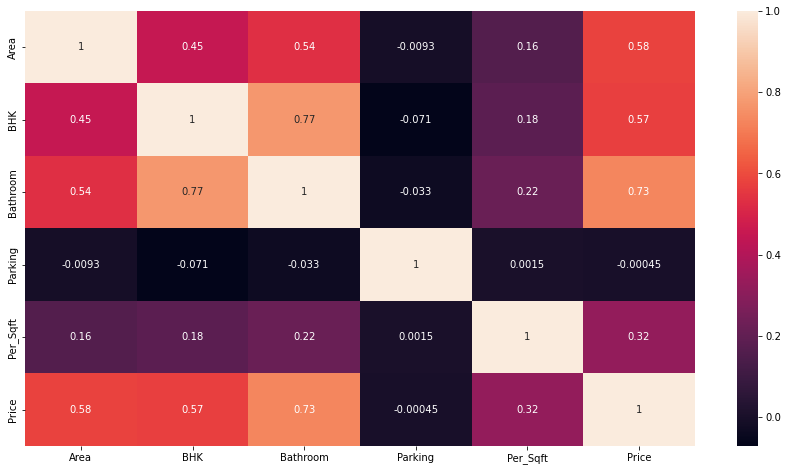

In [849]:
sns.heatmap(df.corr(),annot=True)
plt.show()

In [850]:
df.isnull().sum() 

Area             1
BHK              1
Bathroom         3
Furnishing       6
Locality         1
Parking         34
Status           1
Transaction      1
Type             6
Per_Sqft       242
Price            1
dtype: int64

- From domain knowledge, Price = Area * Price per sq ft, so replacing all null values using the formula

In [851]:
df['Per_Sqft'].fillna(df['Price']/df['Area'],inplace=True)

Filling Numerical Parking and Bathroom column null values with median values

In [852]:
df['Parking'].fillna(df['Parking'].median(),inplace=True)

In [853]:
df['Bathroom'].fillna(df['Bathroom'].median(),inplace=True)

- There are 5 rows where furnishing column has null values, the same five rows have null values in Type column also
- Compared to the overall number of rows, these 5 rows account for hardly 0.3%
- so, dropping these 5 rows

In [854]:
df[df['Furnishing'].isnull()]

,Area,BHK,Bathroom,Furnishing,Locality,Parking,Status,Transaction,Type,Per_Sqft,Price
509,450.0,2.0,2.0,NaN,Shahdara,1.0,Ready_to_move,Resale,NaN,58000.0,2900000.0
510,540.0,5.0,2.0,NaN,Shahdara,1.0,Ready_to_move,Resale,NaN,58000.0,17000000.0
511,1350.0,3.0,3.0,NaN,Shahdara,1.0,Ready_to_move,Resale,NaN,18519.0,25000000.0
512,2250.0,3.0,2.0,NaN,Shahdara,1.0,Ready_to_move,Resale,NaN,4444.0,10000000.0
525,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
719,1500.0,3.0,2.0,NaN,Sarita Vihar,1.0,Ready_to_move,Resale,NaN,9000.0,13500000.0


In [855]:
df = df[~df['Furnishing'].isnull()]

In [856]:
df.isnull().sum()

Area           0
BHK            0
Bathroom       0
Furnishing     0
Locality       0
Parking        0
Status         0
Transaction    0
Type           0
Per_Sqft       0
Price          0
dtype: int64

- Treated Null values

### Outlier Treatment

In [857]:
df.head()

,Area,BHK,Bathroom,Furnishing,Locality,Parking,Status,Transaction,Type,Per_Sqft,Price
0,800.0,3.0,2.0,Semi-Furnished,Rohini,1.0,Ready_to_move,New_Property,Builder_Floor,8125.0,6500000.0
1,750.0,2.0,2.0,Semi-Furnished,Rohini,1.0,Ready_to_move,New_Property,Apartment,6667.0,5000000.0
2,950.0,2.0,2.0,Furnished,Rohini,1.0,Ready_to_move,Resale,Apartment,6667.0,15500000.0
3,600.0,2.0,2.0,Semi-Furnished,Rohini,1.0,Ready_to_move,Resale,Builder_Floor,6667.0,4200000.0
4,650.0,2.0,2.0,Semi-Furnished,Rohini,1.0,Ready_to_move,New_Property,Builder_Floor,6667.0,6200000.0


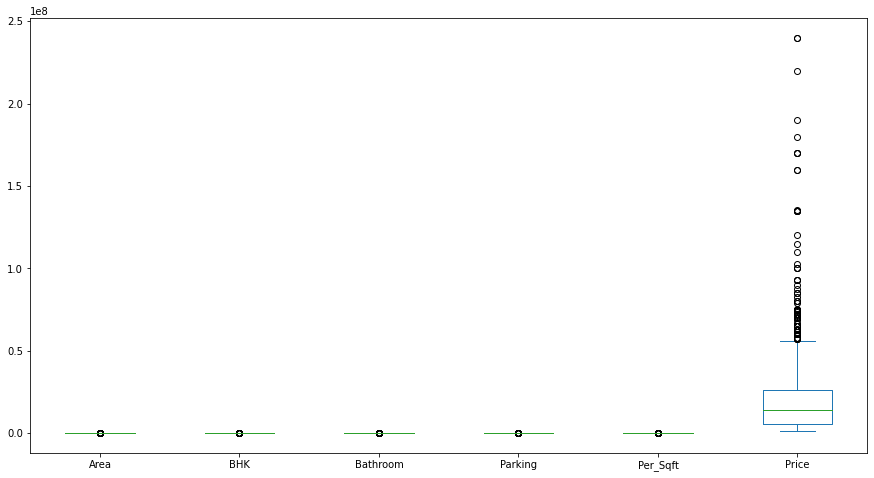

In [858]:
df.plot(kind='box')
plt.show()

<AxesSubplot:>

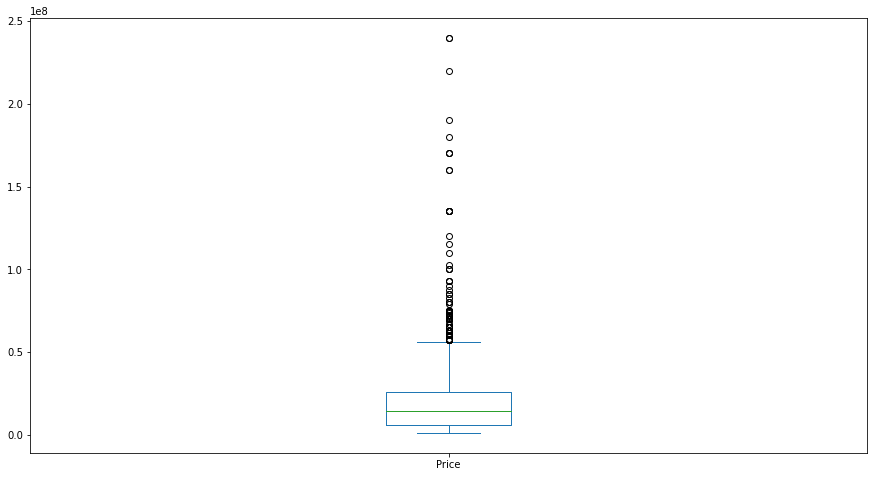

In [859]:
df['Price'].plot(kind='box')

<AxesSubplot:>

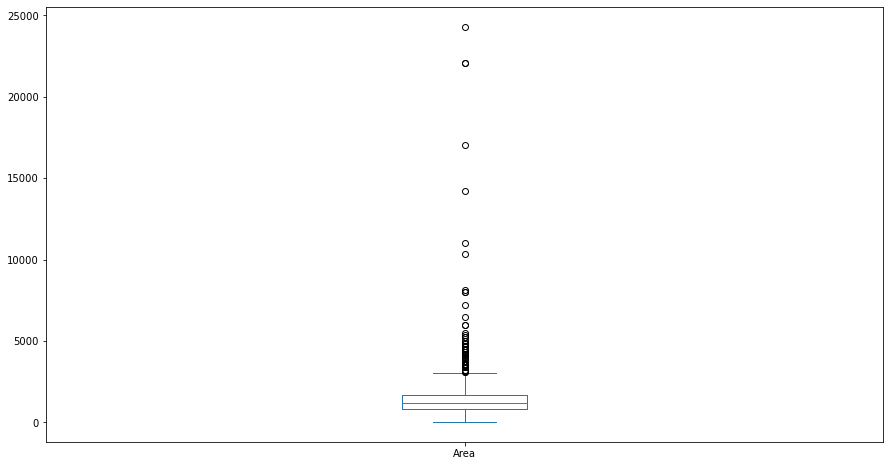

In [860]:
df['Area'].plot(kind='box')

- There are outliers in all columns
- As there are many outliers, treating them would lead to data manipulation. So, leaving them be for base model

### Bivariate Analysis with Target Variable

<Figure size 1440x2160 with 0 Axes>

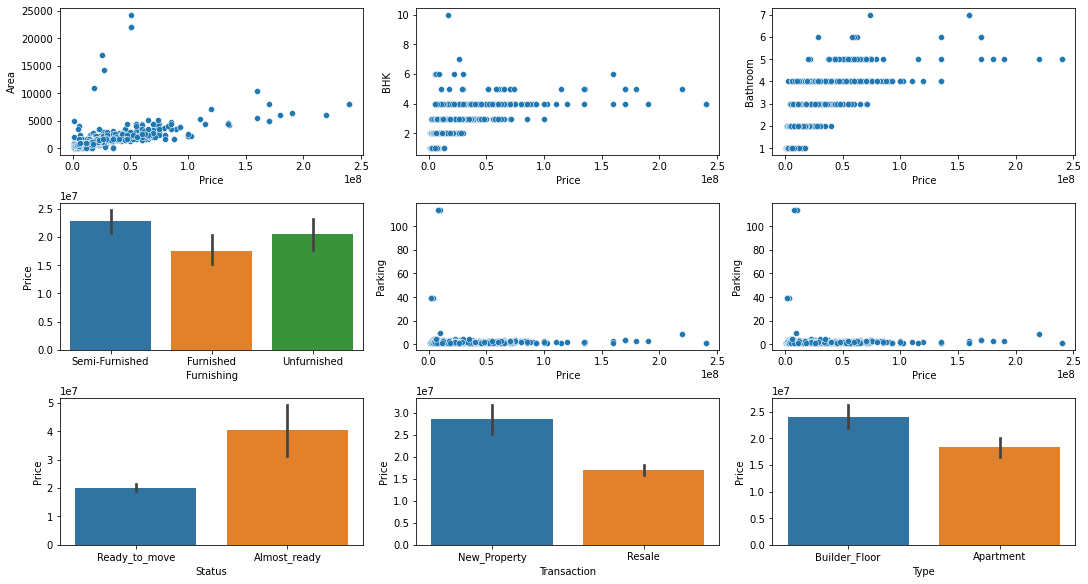

In [861]:
plt.figure(figsize=[20,30])
fig,axes = plt.subplots(3,3,constrained_layout = True)
for i,sp in zip(range(10),axes.flatten()):
    if i == 4:
        i = i+1
    if df.iloc[:,i].dtypes == np.number:
        sns.scatterplot(df['Price'],df.iloc[:,i],ax=sp)
    else:
        sns.barplot(df.iloc[:,i],df['Price'],ax=sp)
plt.show()

From above graphs, we can see that
- Area and Price are directly proportional, Higher the area, higher the price
- Price is higher for Semi furnished, then unfurnished and last furnished
- Price is higher for Almost ready buildings
- Price is higher for New property than Resale property
- Price is higher for Property type Builder floor than Apartment 

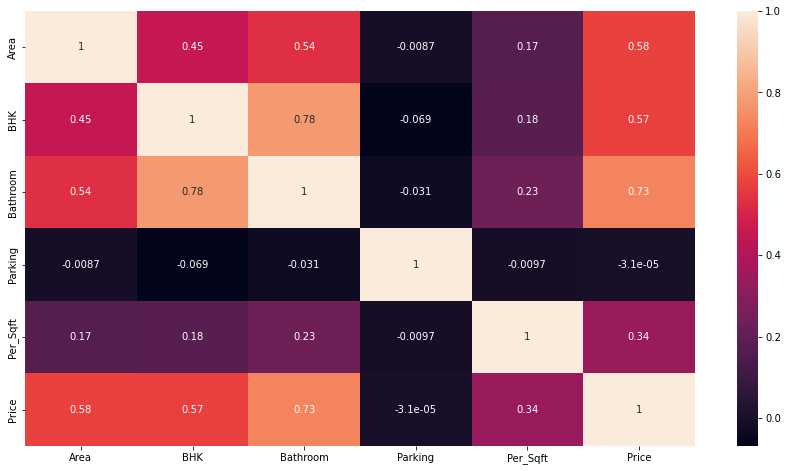

In [862]:
sns.heatmap(df.corr(),annot=True)
plt.show()

Parking has very low correlation with Target variable price, So dropping it

In [863]:
df.drop('Parking',axis=1,inplace=True)

### Encoding

In [864]:
df.dtypes

Area           float64
BHK            float64
Bathroom       float64
Furnishing      object
Locality        object
Status          object
Transaction     object
Type            object
Per_Sqft       float64
Price          float64
dtype: object

In [865]:
df.describe(include='object')

,Furnishing,Locality,Status,Transaction,Type
count,1253,1253,1253,1253,1253
unique,3,42,2,2,2
top,Semi-Furnished,Lajpat Nagar,Ready_to_move,Resale,Builder_Floor
freq,708,90,1178,776,661


- As all the categorical columns are nominal, encoding them using get dummies

In [866]:
df1 = pd.get_dummies(data=df,columns=['Furnishing','Status','Transaction','Type'],drop_first=True)

In [867]:
df1['Locality'].value_counts()

Lajpat Nagar                  90
Dwarka                        86
Rohini                        75
Shahdara                      72
Alaknanda                     58
Greater Kailash               42
Patel Nagar                   35
Okhla                         35
Laxmi Nagar                   34
Vasant Kunj                   33
Karol Bagh                    32
Kalkaji                       32
Sheikh Sarai Phase            30
Kirti Nagar                   30
Vasundhara Enclave            30
Punjabi Bagh                  30
Dilshad Garden                30
Malviya Nagar                 30
Narela                        30
Mahavir Enclave               30
Mehrauli                      30
Hauz Khas                     30
Chhattarpur                   30
Sultanpur                     30
Saket                         30
Commonwealth Games Village    30
New Friends Colony            30
Paschim Vihar                 30
Safdarjung Enclave            30
Uttam Nagar                   29
Chittaranj

Binning Locality into North, South, East, West, Central based on domain knowledge in New column Loaclity_bin

- north = ['Rohini','Budh Vihar','Shahdara' , 'Chandni Chowk', 'Commonwealth Games Village', 'Narela', 'Sheikh Sarai Phase']
- south =  ['Lajpat Nagar','Greater Kailash','Okhla','Janakpuri', 'Najafgarh', 'Vasant Vihar', 'Vasant Kunj', 'New Friends Colony','Madangir', 'Saket', 'Safdarjung', 'Dwarka', 'Alaknanda', 'Sarita Vihar', 'Sultanpur', 'Chhattarpur', 'Mehrauli','Malviya Nagar','Greater Kailash', 'Kalkaji', 'Hauz Khas', 'Chittaranjan Park' ]
- west = ['Dwarka','Patel Nagar',' Uttam Nagar','Baljit Nagar', 'Paschim Vihar', 'Mahavir Enclave', 'Kirti Nagar', 'Punjabi Bagh']
- central = ['Karol Bagh','Ring Road']
- east = ['Laxmi Nagar', 'Geeta Colony', 'Krishna Nagar','Dilshad Garden', 'Vasundhara Enclave', 

In [868]:
df1['Locality_bin'] = df1['Locality'].replace(['Rohini','Budh Vihar','Shahdara' , 'Chandni Chowk',
                                               'Commonwealth Games Village', 'Narela', 'Sheikh Sarai Phase'],
                                              'North').replace(['Lajpat Nagar','Greater Kailash','Okhla','Janakpuri',
                                                                'Najafgarh', 'Vasant Vihar', 'Vasant Kunj', 'New Friends Colony',
                                                                'Madangir', 'Saket', 'Safdarjung Enclave', 'Dwarka', 'Alaknanda',
                                                                'Sarita Vihar','Sultanpur', 'Chhattarpur', 'Mehrauli',
                                                                'Malviya Nagar','Greater Kailash', 'Kalkaji', 'Hauz Khas', 
                                                                'Chittaranjan Park' ],'South'
                                                              ).replace(['Dwarka','Patel Nagar','Uttam Nagar',
                                                                         'Baljit Nagar', 'Paschim Vihar','Mahavir Enclave',
                                                                         'Kirti Nagar', 'Punjabi Bagh'],'West'
                                                                       ).replace(['Karol Bagh','Ring Road'],'Central'
                                                                                ).replace(['Laxmi Nagar','Geeta Colony',
                                                                                           'Krishna Nagar','Dilshad Garden',
                                                                                           'Vasundhara Enclave'],'East')

In [869]:
df1

,Area,BHK,Bathroom,Locality,Per_Sqft,Price,Furnishing_Semi-Furnished,Furnishing_Unfurnished,Status_Ready_to_move,Transaction_Resale,Type_Builder_Floor,Locality_bin
0,800.0,3.0,2.0,Rohini,8125.0,6500000.0,1,0,1,0,1,North
1,750.0,2.0,2.0,Rohini,6667.0,5000000.0,1,0,1,0,0,North
2,950.0,2.0,2.0,Rohini,6667.0,15500000.0,0,0,1,1,0,North
3,600.0,2.0,2.0,Rohini,6667.0,4200000.0,1,0,1,1,1,North
4,650.0,2.0,2.0,Rohini,6667.0,6200000.0,1,0,1,0,1,North
...,...,...,...,...,...,...,...,...,...,...,...,...
1254,4118.0,4.0,5.0,Chittaranjan Park,12916.0,55000000.0,0,1,1,0,1,South
1255,1050.0,3.0,2.0,Chittaranjan Park,12916.0,12500000.0,1,0,1,1,1,South
1256,875.0,3.0,3.0,Chittaranjan Park,12916.0,17500000.0,1,0,1,0,1,South
1257,990.0,2.0,2.0,Chittaranjan Park,12916.0,11500000.0,0,1,1,1,1,South


Dropping Locality column as we have Locality_bin and encoding it

In [870]:
df1.drop('Locality',axis=True,inplace=True)

In [871]:
df1['Locality_bin'].unique()

array(['North', 'South', 'West', 'Central', 'East'], dtype=object)

In [872]:
df1

,Area,BHK,Bathroom,Per_Sqft,Price,Furnishing_Semi-Furnished,Furnishing_Unfurnished,Status_Ready_to_move,Transaction_Resale,Type_Builder_Floor,Locality_bin
0,800.0,3.0,2.0,8125.0,6500000.0,1,0,1,0,1,North
1,750.0,2.0,2.0,6667.0,5000000.0,1,0,1,0,0,North
2,950.0,2.0,2.0,6667.0,15500000.0,0,0,1,1,0,North
3,600.0,2.0,2.0,6667.0,4200000.0,1,0,1,1,1,North
4,650.0,2.0,2.0,6667.0,6200000.0,1,0,1,0,1,North
...,...,...,...,...,...,...,...,...,...,...,...
1254,4118.0,4.0,5.0,12916.0,55000000.0,0,1,1,0,1,South
1255,1050.0,3.0,2.0,12916.0,12500000.0,1,0,1,1,1,South
1256,875.0,3.0,3.0,12916.0,17500000.0,1,0,1,0,1,South
1257,990.0,2.0,2.0,12916.0,11500000.0,0,1,1,1,1,South


In [873]:
df1 = pd.get_dummies(data=df1,columns=['Locality_bin'],drop_first=True)

In [874]:
df1

,Area,BHK,Bathroom,Per_Sqft,Price,Furnishing_Semi-Furnished,Furnishing_Unfurnished,Status_Ready_to_move,Transaction_Resale,Type_Builder_Floor,Locality_bin_East,Locality_bin_North,Locality_bin_South,Locality_bin_West
0,800.0,3.0,2.0,8125.0,6500000.0,1,0,1,0,1,0,1,0,0
1,750.0,2.0,2.0,6667.0,5000000.0,1,0,1,0,0,0,1,0,0
2,950.0,2.0,2.0,6667.0,15500000.0,0,0,1,1,0,0,1,0,0
3,600.0,2.0,2.0,6667.0,4200000.0,1,0,1,1,1,0,1,0,0
4,650.0,2.0,2.0,6667.0,6200000.0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,4118.0,4.0,5.0,12916.0,55000000.0,0,1,1,0,1,0,0,1,0
1255,1050.0,3.0,2.0,12916.0,12500000.0,1,0,1,1,1,0,0,1,0
1256,875.0,3.0,3.0,12916.0,17500000.0,1,0,1,0,1,0,0,1,0
1257,990.0,2.0,2.0,12916.0,11500000.0,0,1,1,1,1,0,0,1,0


In [875]:
x = df1.drop('Price',axis=1)
y = df1['Price']
x = sm.add_constant(x)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.25,random_state=10)

In [876]:
model1 = sm.OLS(ytrain,xtrain).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     152.4
Date:                Mon, 09 May 2022   Prob (F-statistic):          2.51e-219
Time:                        11:58:21   Log-Likelihood:                -16765.
No. Observations:                 939   AIC:                         3.356e+04
Df Residuals:                     925   BIC:                         3.363e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -1.399e+07   3.44e+06     -4.071      0.000   -2.07e+07   -7.24e+06
Area                       8277.6691    501.305     16.512      0.000    7293.841    9261.497
BHK                       -4.306e+05   7.76e+05     -0.555      0.579   -1.95e+06    1.09e+06
Bathroom                   9.956e+06   7.76e+05     12.822      0.000    8.43e+06    1.15e+07
Per_Sqft                    231.8416     24.366      9.515      0.000     184.023     279.661
Furnishing_Semi-Furnished -5.343e+05   1.37e+06     -0.391      0.696   -3.21e+06    2.15e+06
Furnishing_Unfurnished     5.992e+05   1.49e+06      0.401      0.689   -2.33e+06    3.53e+06
Status_Ready_to_move       -6.16e+06   2.21e+06     -2.793      0.005   -1.05e+07   -1.83e+06
Transaction_Resale        -3.571e+06   1.02e+06     -3.503      0.000   -5.57e+06   -1.57e+06
Type_Builder_Floor        -4.284e+05    9.4e+05     -0.456      0.649   -2.27e+06    1.42e+06
Locality_bin_East          3.185e+06    3.2e+06      0.994      0.320    -3.1e+06    9.47e+06
Locality_bin_North         2.581e+06   2.89e+06      0.894      0.372   -3.09e+06    8.25e+06
Locality_bin_South         5.528e+06   2.78e+06      1.991      0.047    7.99e+04     1.1e+07
Locality_bin_West          3.096e+06   2.94e+06      1.052      0.293   -2.68e+06    8.87e+06
==============================================================================
Omnibus:                      429.750   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33364.840
Skew:                           1.188   Prob(JB):                         0.00
Kurtosis:                      32.105   Cond. No.                     3.24e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [877]:
scorecard = DataFrame(columns=['Model','R2','R2adj','RMSE','Condition Number'])

In [878]:
def up_scorecard(model,text,r2='-',r2adj = '-'):
    global scorecard
    ypred = model.predict(xtest)
    r2 = model.rsquared
    r2adj = model.rsquared_adj
    rmse = np.sqrt(mean_squared_error(ypred,ytest))
    cn = model.condition_number
    scorecard = scorecard.append({'Model':text,'R2':r2,'R2adj':r2adj,
                     'RMSE':rmse,'Condition Number': cn},ignore_index=True)   

In [879]:
up_scorecard(model1,'Base Model')

In [880]:
scorecard

,Model,R2,R2adj,RMSE,Condition Number
0,Base Model,0.681645,0.677171,2.363522e+07,323989.949537


### Addressing Multi Collinearity for Numerical Columns

In [881]:
x.head()

,const,Area,BHK,Bathroom,Per_Sqft,Furnishing_Semi-Furnished,Furnishing_Unfurnished,Status_Ready_to_move,Transaction_Resale,Type_Builder_Floor,Locality_bin_East,Locality_bin_North,Locality_bin_South,Locality_bin_West
0,1.0,800.0,3.0,2.0,8125.0,1,0,1,0,1,0,1,0,0
1,1.0,750.0,2.0,2.0,6667.0,1,0,1,0,0,0,1,0,0
2,1.0,950.0,2.0,2.0,6667.0,0,0,1,1,0,0,1,0,0
3,1.0,600.0,2.0,2.0,6667.0,1,0,1,1,1,0,1,0,0
4,1.0,650.0,2.0,2.0,6667.0,1,0,1,0,1,0,1,0,0


In [882]:
df_num = x.iloc[:,1:6]

In [883]:
df_num.head()

,Area,BHK,Bathroom,Per_Sqft,Furnishing_Semi-Furnished
0,800.0,3.0,2.0,8125.0,1
1,750.0,2.0,2.0,6667.0,1
2,950.0,2.0,2.0,6667.0,0
3,600.0,2.0,2.0,6667.0,1
4,650.0,2.0,2.0,6667.0,1


In [884]:
for j in range(len(df_num.columns)):
    vif = DataFrame()
    vif['vif factor'] = [variance_inflation_factor(df_num.values,i) for i in range(len(df_num.columns))]
    vif['features'] = df_num.columns
    
    vif.sort_values(by='vif factor',ascending=False,inplace=True)
    print(vif)
    
    if vif.iloc[0,0]>10:
        print('dropping: ',vif.iloc[0,1])
        df_num.drop(vif.iloc[0,1],axis=1,inplace=True)
    else:
        print(vif)
        break

   vif factor                   features
2   19.869483                   Bathroom
1   17.937570                        BHK
0    2.563270                       Area
4    2.148845  Furnishing_Semi-Furnished
3    1.697801                   Per_Sqft
dropping:  Bathroom
   vif factor                   features
1    3.884398                        BHK
0    2.327224                       Area
3    2.128472  Furnishing_Semi-Furnished
2    1.667404                   Per_Sqft
   vif factor                   features
1    3.884398                        BHK
0    2.327224                       Area
3    2.128472  Furnishing_Semi-Furnished
2    1.667404                   Per_Sqft


In [885]:
df_num.columns

Index(['Area', 'BHK', 'Per_Sqft', 'Furnishing_Semi-Furnished'], dtype='object')

In [886]:
xtrain.head()

,const,Area,BHK,Bathroom,Per_Sqft,Furnishing_Semi-Furnished,Furnishing_Unfurnished,Status_Ready_to_move,Transaction_Resale,Type_Builder_Floor,Locality_bin_East,Locality_bin_North,Locality_bin_South,Locality_bin_West
659,1.0,3050.0,5.0,6.0,20492.0,1,0,1,1,0,0,1,0,0
866,1.0,360.0,2.0,1.0,42222.0,1,0,1,0,0,0,0,0,1
940,1.0,800.0,3.0,2.0,9200.0,1,0,1,1,0,1,0,0,0
744,1.0,1800.0,4.0,4.0,6667.0,0,0,1,0,0,0,0,0,0
6,1.0,1350.0,4.0,3.0,6667.0,1,0,1,1,1,0,1,0,0


In [887]:
xtrain = xtrain.drop(['Bathroom'],axis=1)
xtest = xtest.drop('Bathroom',axis=1)

In [888]:
model2 = sm.OLS(ytrain,xtrain).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     128.6
Date:                Mon, 09 May 2022   Prob (F-statistic):          9.71e-188
Time:                        11:58:22   Log-Likelihood:                -16842.
No. Observations:                 939   AIC:                         3.371e+04
Df Residuals:                     926   BIC:                         3.377e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -1.042e+07   3.71e+06     -2.805      0.005   -1.77e+07   -3.13e+06
Area                       1.048e+04    510.925     20.505      0.000    9474.071    1.15e+04
BHK                        6.285e+06   6.21e+05     10.119      0.000    5.07e+06     7.5e+06
Per_Sqft                    258.7649     26.330      9.828      0.000     207.091     310.439
Furnishing_Semi-Furnished  6.573e+05   1.48e+06      0.445      0.657   -2.24e+06    3.56e+06
Furnishing_Unfurnished     1.659e+06   1.62e+06      1.025      0.306   -1.52e+06    4.84e+06
Status_Ready_to_move      -6.782e+06   2.39e+06     -2.835      0.005   -1.15e+07   -2.09e+06
Transaction_Resale        -4.427e+06    1.1e+06     -4.012      0.000   -6.59e+06   -2.26e+06
Type_Builder_Floor         1.679e+05   1.02e+06      0.165      0.869   -1.83e+06    2.17e+06
Locality_bin_East          1.178e+06   3.47e+06      0.340      0.734   -5.63e+06    7.99e+06
Locality_bin_North         1.387e+06   3.13e+06      0.443      0.658   -4.76e+06    7.53e+06
Locality_bin_South         5.653e+06   3.01e+06      1.878      0.061   -2.55e+05    1.16e+07
Locality_bin_West          1.543e+06   3.19e+06      0.484      0.629   -4.71e+06     7.8e+06
==============================================================================
Omnibus:                      291.769   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37374.540
Skew:                          -0.116   Prob(JB):                         0.00
Kurtosis:                      33.906   Cond. No.                     3.24e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [889]:
up_scorecard(model2,'M2: After adressing Mutli Collinearity')

In [890]:
scorecard

,Model,R2,R2adj,RMSE,Condition Number
0,Base Model,0.681645,0.677171,2.363522e+07,323989.949537
1,M2: After adressing Mutli Collinearity,0.625064,0.620206,2.725599e+07,323638.261781


### Scaling

In [891]:
xtrain.head()

,const,Area,BHK,Per_Sqft,Furnishing_Semi-Furnished,Furnishing_Unfurnished,Status_Ready_to_move,Transaction_Resale,Type_Builder_Floor,Locality_bin_East,Locality_bin_North,Locality_bin_South,Locality_bin_West
659,1.0,3050.0,5.0,20492.0,1,0,1,1,0,0,1,0,0
866,1.0,360.0,2.0,42222.0,1,0,1,0,0,0,0,0,1
940,1.0,800.0,3.0,9200.0,1,0,1,1,0,1,0,0,0
744,1.0,1800.0,4.0,6667.0,0,0,1,0,0,0,0,0,0
6,1.0,1350.0,4.0,6667.0,1,0,1,1,1,0,1,0,0


In [892]:
from sklearn.preprocessing import StandardScaler
SS=StandardScaler()
xtrain.iloc[:,1:5] = SS.fit_transform(xtrain.iloc[:,1:5])
xtest.iloc[:,1:5] = SS.transform(xtest.iloc[:,1:5])

In [893]:
xtrain.head()

,const,Area,BHK,Per_Sqft,Furnishing_Semi-Furnished,Furnishing_Unfurnished,Status_Ready_to_move,Transaction_Resale,Type_Builder_Floor,Locality_bin_East,Locality_bin_North,Locality_bin_South,Locality_bin_West
659,1.0,1.405917,2.325762,0.285070,0.874664,0,1,1,0,0,1,0,0
866,1.0,-0.901715,-0.819544,1.407833,0.874664,0,1,0,0,0,0,0,1
940,1.0,-0.524258,0.228892,-0.298373,0.874664,0,1,1,0,1,0,0,0
744,1.0,0.333597,1.277327,-0.429250,-1.143296,0,1,0,0,0,0,0,0
6,1.0,-0.052438,1.277327,-0.429250,0.874664,0,1,1,1,0,1,0,0


As Prob of JB value is less than 0.05, the normality of residuals condition is not satisfied. Hence, we are doing transformation

In [894]:
model5 = sm.OLS(ytrain,xtrain).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     128.6
Date:                Mon, 09 May 2022   Prob (F-statistic):          9.71e-188
Time:                        11:59:47   Log-Likelihood:                -16842.
No. Observations:                 939   AIC:                         3.371e+04
Df Residuals:                     926   BIC:                         3.377e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2.609e+07   3.18e+06      8.214      0.000    1.99e+07    3.23e+07
Area                       1.221e+07   5.96e+05     20.505      0.000     1.1e+07    1.34e+07
BHK                        5.994e+06   5.92e+05     10.119      0.000    4.83e+06    7.16e+06
Per_Sqft                   5.008e+06    5.1e+05      9.828      0.000    4.01e+06    6.01e+06
Furnishing_Semi-Furnished  3.257e+05   7.32e+05      0.445      0.657   -1.11e+06    1.76e+06
Furnishing_Unfurnished     1.659e+06   1.62e+06      1.025      0.306   -1.52e+06    4.84e+06
Status_Ready_to_move      -6.782e+06   2.39e+06     -2.835      0.005   -1.15e+07   -2.09e+06
Transaction_Resale        -4.427e+06    1.1e+06     -4.012      0.000   -6.59e+06   -2.26e+06
Type_Builder_Floor         1.679e+05   1.02e+06      0.165      0.869   -1.83e+06    2.17e+06
Locality_bin_East          1.178e+06   3.47e+06      0.340      0.734   -5.63e+06    7.99e+06
Locality_bin_North         1.387e+06   3.13e+06      0.443      0.658   -4.76e+06    7.53e+06
Locality_bin_South         5.653e+06   3.01e+06      1.878      0.061   -2.55e+05    1.16e+07
Locality_bin_West          1.543e+06   3.19e+06      0.484      0.629   -4.71e+06     7.8e+06
==============================================================================
Omnibus:                      291.769   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37374.540
Skew:                          -0.116   Prob(JB):                         0.00
Kurtosis:                      33.906   Cond. No.                         23.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [896]:
up_scorecard(model5,'M5: After scaling')

In [897]:
scorecard

,Model,R2,R2adj,RMSE,Condition Number
0,Base Model,0.681645,0.677171,2.363522e+07,323989.949537
1,M2: After adressing Mutli Collinearity,0.625064,0.620206,2.725599e+07,323638.261781
2,M5: After scaling,0.625064,0.620206,2.725599e+07,23.260275


<AxesSubplot:>

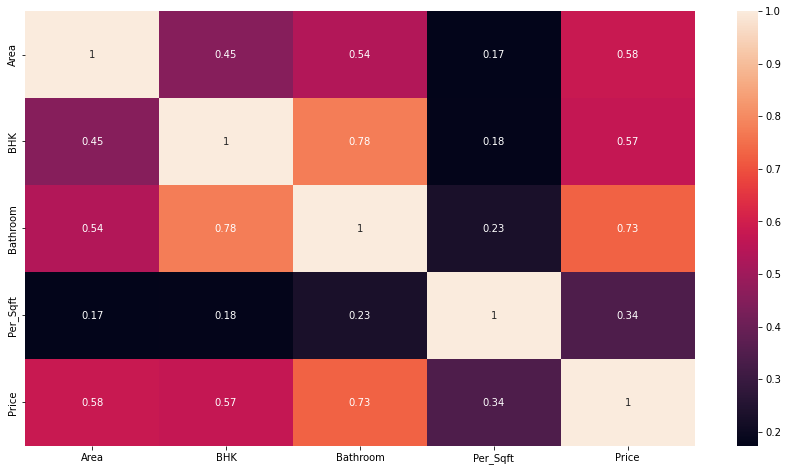

In [899]:
sns.heatmap(df.corr(),annot=True)

<AxesSubplot:>

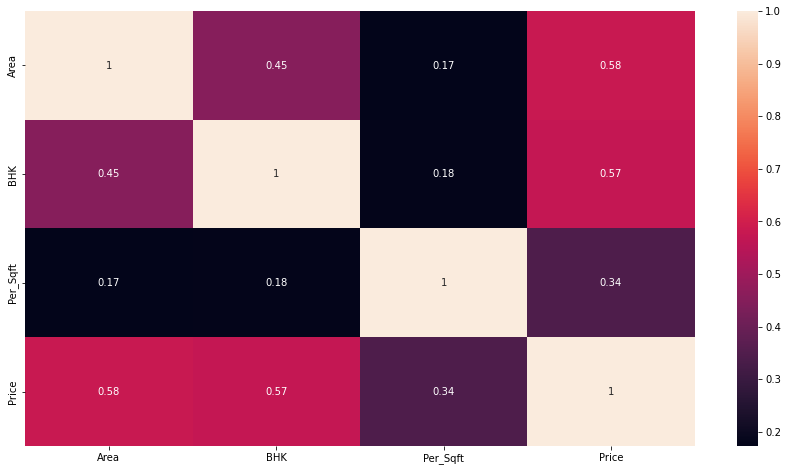

In [900]:
sns.heatmap(df.drop('Bathroom',axis=1).corr(),annot=True)

In [ ]:
df

### Transformation

In [828]:
y.skew()

3.490609164870572

In [829]:
np.log(y).skew()

-0.031105407349531277

- Log transformation makes the target variable near normal
- So, building a model after scaling and transforming

In [830]:
ytrain = np.log(ytrain)
ytest = np.log(ytest)

In [831]:
model3 = sm.OLS(ytrain,xtrain).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     145.2
Date:                Mon, 09 May 2022   Prob (F-statistic):          3.30e-203
Time:                        11:58:00   Log-Likelihood:                -881.81
No. Observations:                 939   AIC:                             1790.
Df Residuals:                     926   BIC:                             1853.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        16.8057      0.132    127.426      0.000      16.547      17.065
Area                          0.3200      0.025     12.939      0.000       0.271       0.368
BHK                           0.4972      0.025     20.213      0.000       0.449       0.545
Per_Sqft                      0.1705      0.021      8.060      0.000       0.129       0.212
Furnishing_Semi-Furnished    -0.0044      0.030     -0.144      0.885      -0.064       0.055
Furnishing_Unfurnished       -0.0824      0.067     -1.226      0.220      -0.214       0.050
Status_Ready_to_move         -0.2873      0.099     -2.893      0.004      -0.482      -0.092
Transaction_Resale            0.0729      0.046      1.592      0.112      -0.017       0.163
Type_Builder_Floor           -0.0731      0.042     -1.729      0.084      -0.156       0.010
Locality_bin_East            -0.4136      0.144     -2.870      0.004      -0.696      -0.131
Locality_bin_North           -0.4855      0.130     -3.735      0.000      -0.741      -0.230
Locality_bin_South            0.0116      0.125      0.093      0.926      -0.234       0.257
Locality_bin_West            -0.2949      0.132     -2.228      0.026      -0.555      -0.035
==============================================================================
Omnibus:                      158.956   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              404.215
Skew:                          -0.892   Prob(JB):                     1.68e-88
Kurtosis:                       5.673   Cond. No.                         23.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [832]:
up_scorecard(model3,'M3: After Scaling and Transforming')

In [833]:
scorecard

,Model,R2,R2adj,RMSE,Condition Number
0,Base Model,0.681645,0.677171,2.363522e+07,323989.949537
1,M2: After adressing Mutli Collinearity,0.625064,0.620206,2.725599e+07,323638.261781
2,M3: After Scaling and Transforming,0.652990,0.648493,8.465725e-01,23.260275


### Forward Selection

In [834]:
df1.head()

,Area,BHK,Bathroom,Per_Sqft,Price,Furnishing_Semi-Furnished,Furnishing_Unfurnished,Status_Ready_to_move,Transaction_Resale,Type_Builder_Floor,Locality_bin_East,Locality_bin_North,Locality_bin_South,Locality_bin_West
0,800.0,3.0,2.0,8125.0,6500000.0,1,0,1,0,1,0,1,0,0
1,750.0,2.0,2.0,6667.0,5000000.0,1,0,1,0,0,0,1,0,0
2,950.0,2.0,2.0,6667.0,15500000.0,0,0,1,1,0,0,1,0,0
3,600.0,2.0,2.0,6667.0,4200000.0,1,0,1,1,1,0,1,0,0
4,650.0,2.0,2.0,6667.0,6200000.0,1,0,1,0,1,0,1,0,0


In [835]:
x = df1.drop('Price',axis=1)
y = df1['Price']
x = sm.add_constant(x)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.25,random_state=10)

In [836]:
linreg = LinearRegression()
linreg_for = sfs(estimator=linreg,verbose=2,forward=True,k_features='best',scoring='r2')
model4 = linreg_for.fit(xtrain.drop('const',axis=1),ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished

[2022-05-09 11:58:00] Features: 1/13 -- score: 0.5358293735894935[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished

[2022-05-09 11:58:00] Features: 2/13 -- score: 0.5709659756679589[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s finished

[2022-05-09 11:58:00] Features: 3/13 -- score: 0.5972800212704451[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [837]:
model4.k_feature_names_

('Area',
 'Bathroom',
 'Per_Sqft',
 'Furnishing_Unfurnished',
 'Status_Ready_to_move',
 'Transaction_Resale',
 'Locality_bin_South')

In [838]:
xtrain = xtrain[['const','Area', 'Bathroom', 'Per_Sqft', 'Furnishing_Unfurnished',
                 'Status_Ready_to_move', 'Transaction_Resale', 'Locality_bin_South']]
xtest = xtest[['const','Area', 'Bathroom', 'Per_Sqft', 'Furnishing_Unfurnished',
                 'Status_Ready_to_move', 'Transaction_Resale', 'Locality_bin_South']]

In [839]:
from sklearn.preprocessing import StandardScaler
SS=StandardScaler()
xtrain.iloc[:,1:5] = SS.fit_transform(xtrain.iloc[:,1:5])
xtest.iloc[:,1:5] = SS.transform(xtest.iloc[:,1:5])

In [840]:
ytrain = np.log(ytrain)
ytest = np.log(ytest)

In [841]:
model4 = sm.OLS(ytrain,xtrain).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     307.8
Date:                Mon, 09 May 2022   Prob (F-statistic):          3.18e-237
Time:                        11:58:01   Log-Likelihood:                -816.11
No. Observations:                 939   AIC:                             1648.
Df Residuals:                     931   BIC:                             1687.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     16.4608      0.085    193.017      0.000      16.293      16.628
Area                       0.2216      0.024      9.166      0.000       0.174       0.269
Bathroom                   0.6223      0.025     25.142      0.000       0.574       0.671
Per_Sqft                   0.1471      0.020      7.490      0.000       0.109       0.186
Furnishing_Unfurnished    -0.0453      0.019     -2.371      0.018      -0.083      -0.008
Status_Ready_to_move      -0.3927      0.088     -4.449      0.000      -0.566      -0.219
Transaction_Resale         0.1542      0.041      3.745      0.000       0.073       0.235
Locality_bin_South         0.3025      0.039      7.731      0.000       0.226       0.379
==============================================================================
Omnibus:                       38.181   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.783
Skew:                          -0.504   Prob(JB):                     8.45e-10
Kurtosis:                       3.228   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [842]:
up_scorecard(model4,'M4: After best forward selection, scaling and transforming')

In [843]:
scorecard

,Model,R2,R2adj,RMSE,Condition Number
0,Base Model,0.681645,0.677171,2.363522e+07,323989.949537
1,M2: After adressing Mutli Collinearity,0.625064,0.620206,2.725599e+07,323638.261781
2,M3: After Scaling and Transforming,0.652990,0.648493,8.465725e-01,23.260275
3,"M4: After best forward selection, scaling and ...",0.698305,0.696036,7.221918e-01,10.369369


From the above score card, we can conclude that
- Model4 is the best model amongst all we've built: Has the highest R squared and Adj R squared values, lowest RMSE and condition number values
- DB Value is almost close to 2, which indicates that there is no Auto correlation
- Forward selection with best features is done for Feature selection
- Scaling is done on numerical columns to standardize them
- Log transformation has been applied on target variable for normality of the residuals